# Pipeline end-to-end untuk clustering model machine learning:
## 1. Pengumpulan & pembersihan data (Pandas)
### Import library

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, chi2, f_classif
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as sch
from scipy.stats import chi2_contingency

# Set visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

### Import dataset

In [2]:
# Connecting to Google Drive
drive.mount('/content/drive')

# Importing Dataset
df = pd.read_csv('/content/drive/MyDrive/Belajar (PTA TA)/Tempat Belajar/UTSClustering.csv', encoding='ISO-8859-1')

# Display  dataset
df.info()
df.describe()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Membersihkan data

In [3]:
# Remove rows with missing Description
df = df.dropna(subset=['Description', 'CustomerID'])

### Menambahkan fitur

In [4]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract date components
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the total amount for each transaction
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Filter out cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Filter out entries with negative or zero quantity or price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# For clustering, we need data at the customer level
# We'll focus on customers with CustomerID available
df_customer = df.dropna(subset=['CustomerID'])

print(f"After cleaning, shape: {df_customer.shape}")

# Create customer-level features
print("\n# 2a. Feature Engineering - Customer-Level Aggregation")

# Group by customer and create features
customer_features = df_customer.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',                 # Number of orders
    'StockCode': 'nunique',                # Number of unique products
    'Quantity': ['sum', 'mean'],           # Total and average quantity
    'TotalAmount': ['sum', 'mean'],        # Total and average spending
    'InvoiceDate': ['min', 'max']          # First and last purchase date
}).reset_index()

# Flatten the multi-level column names
customer_features.columns = ['_'.join(col).strip('_') for col in customer_features.columns.values]

# Rename columns for clarity
customer_features.rename(columns={
    'InvoiceNo_nunique': 'total_orders',
    'StockCode_nunique': 'unique_products',
    'Quantity_sum': 'total_quantity',
    'Quantity_mean': 'avg_quantity_per_order',
    'TotalAmount_sum': 'total_spending',
    'TotalAmount_mean': 'avg_spending_per_order',
    'InvoiceDate_min': 'first_purchase',
    'InvoiceDate_max': 'last_purchase'
}, inplace=True)

# Calculate days since last purchase (from the max date in the dataset)
max_date = df_customer['InvoiceDate'].max()
customer_features['days_since_last_purchase'] = (max_date - customer_features['last_purchase']).dt.days

# Calculate customer lifetime in days
customer_features['customer_lifetime'] = (customer_features['last_purchase'] - customer_features['first_purchase']).dt.days

# Create purchase frequency feature (orders per day active)
customer_features['purchase_frequency'] = customer_features['total_orders'] / (customer_features['customer_lifetime'] + 1)  # Add 1 to avoid division by zero

# Calculate average order value
customer_features['avg_order_value'] = customer_features['total_spending'] / customer_features['total_orders']

# Create monetary value range
customer_features['spending_range'] = customer_features['total_spending'].max() - customer_features['total_spending'].min()

# Country-level features (one-hot encoding)
country_dummies = pd.get_dummies(df_customer['Country'], prefix='country')
country_features = country_dummies.groupby(df_customer['CustomerID']).max().reset_index()

# Merge customer features with country features
customer_features = pd.merge(customer_features, country_features, on='CustomerID')

# Drop date columns as they can't be used for clustering directly
customer_features.drop(['first_purchase', 'last_purchase'], axis=1, inplace=True)

print("Final shape of customer features:", customer_features.shape)
print(customer_features.head())

After cleaning, shape: (397884, 14)

# 2a. Feature Engineering - Customer-Level Aggregation
Final shape of customer features: (4338, 49)
   CustomerID  total_orders  unique_products  total_quantity  \
0     12346.0             1                1           74215   
1     12347.0             7              103            2458   
2     12348.0             4               22            2341   
3     12349.0             1               73             631   
4     12350.0             1               17             197   

   avg_quantity_per_order  total_spending  avg_spending_per_order  \
0            74215.000000        77183.60            77183.600000   
1               13.505495         4310.00               23.681319   
2               75.516129         1797.24               57.975484   
3                8.643836         1757.55               24.076027   
4               11.588235          334.40               19.670588   

   days_since_last_purchase  customer_lifetime  purchase_freque

## 2. Feature Selection

In [5]:
# Function to identify and remove constant and quasi-constant features
def remove_constant_features(df, threshold=0.01):
    """
    Remove features with low variance (constant or quasi-constant)
    """
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(df)
    constant_features = [column for column, selected in zip(df.columns, selector.get_support()) if not selected]

    print(f"Constant/Quasi-constant features (variance < {threshold}):")
    print(constant_features)

    return df.loc[:, selector.get_support()]

# Function to remove duplicate features
def remove_duplicate_features(df):
    """
    Remove duplicate features
    """
    # Get duplicate columns
    duplicate_columns = []
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            if df.iloc[:, i].equals(df.iloc[:, j]):
                duplicate_columns.append(df.columns[j])

    if duplicate_columns:
        print("Duplicate columns:")
        print(duplicate_columns)
        df = df.drop(columns=duplicate_columns)
    else:
        print("No duplicate columns found.")

    return df

# Function to check correlation and remove highly correlated features
def remove_correlated_features(df, threshold=0.9):
    """
    Remove features that are highly correlated
    """
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    if to_drop:
        print(f"Features with correlation > {threshold}:")
        for col in to_drop:
            correlated_with = upper.index[upper[col] > threshold].tolist()
            for other_col in correlated_with:
                print(f"  {col} is correlated with {other_col} ({corr_matrix.loc[col, other_col]:.2f})")

        print(f"Dropping: {to_drop}")
        df = df.drop(columns=to_drop)
    else:
        print(f"No features with correlation > {threshold}")

    return df

# Apply feature selection
print("\n# Removing constant and quasi-constant features")
X = remove_constant_features(customer_features.drop('CustomerID', axis=1))

print("\n# Removing duplicate features")
X = remove_duplicate_features(X)

print("\n# Removing highly correlated features")
X = remove_correlated_features(X, threshold=0.9)

print("\n# Final feature set after selection:")
print(X.shape)
print(X.columns.tolist())

print("\n# 2c. Feature Engineering (Transformation & Scaling)")

# Function to detect skewed features and apply log transformation
def transform_skewed_features(df, threshold=1.0):
    """
    Apply log transformation to skewed features
    """
    skewed_features = []
    transformed_df = df.copy()

    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64]:
            skewness = df[column].skew()
            if abs(skewness) > threshold:
                skewed_features.append((column, skewness))
                # Add a small constant to avoid log(0)
                transformed_df[column] = np.log1p(df[column] - df[column].min() + 1)

    if skewed_features:
        print("Skewed features transformed (log transformation):")
        for col, skew in skewed_features:
            print(f"  {col}: skewness = {skew:.2f}")
    else:
        print("No highly skewed features found.")

    return transformed_df

# Apply transformation to skewed features
X_transformed = transform_skewed_features(X, threshold=1.0)

# Scale features
print("\n# Scaling features")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X_transformed.columns)

print("Feature scaling summary:")
print(X_scaled_df.describe().T[['mean', 'std', 'min', 'max']])


# Removing constant and quasi-constant features
Constant/Quasi-constant features (variance < 0.01):
['spending_range', 'country_Australia', 'country_Austria', 'country_Bahrain', 'country_Belgium', 'country_Brazil', 'country_Canada', 'country_Channel Islands', 'country_Cyprus', 'country_Czech Republic', 'country_Denmark', 'country_EIRE', 'country_European Community', 'country_Finland', 'country_Greece', 'country_Iceland', 'country_Israel', 'country_Italy', 'country_Japan', 'country_Lebanon', 'country_Lithuania', 'country_Malta', 'country_Netherlands', 'country_Norway', 'country_Poland', 'country_Portugal', 'country_RSA', 'country_Saudi Arabia', 'country_Singapore', 'country_Spain', 'country_Sweden', 'country_Switzerland', 'country_USA', 'country_United Arab Emirates', 'country_Unspecified']

# Removing duplicate features
No duplicate columns found.

# Removing highly correlated features
Features with correlation > 0.9:
  total_spending is correlated with total_quantity (0.92)
  avg_spe

## 3. Clustering Models


# Finding optimal number of clusters
K = 2, Silhouette Score = 0.3176
K = 3, Silhouette Score = 0.3396
K = 4, Silhouette Score = 0.3632
K = 5, Silhouette Score = 0.2880
K = 6, Silhouette Score = 0.3095
K = 7, Silhouette Score = 0.3143
K = 8, Silhouette Score = 0.2676
K = 9, Silhouette Score = 0.2197
K = 10, Silhouette Score = 0.2233
Optimal number of clusters based on silhouette score: 4


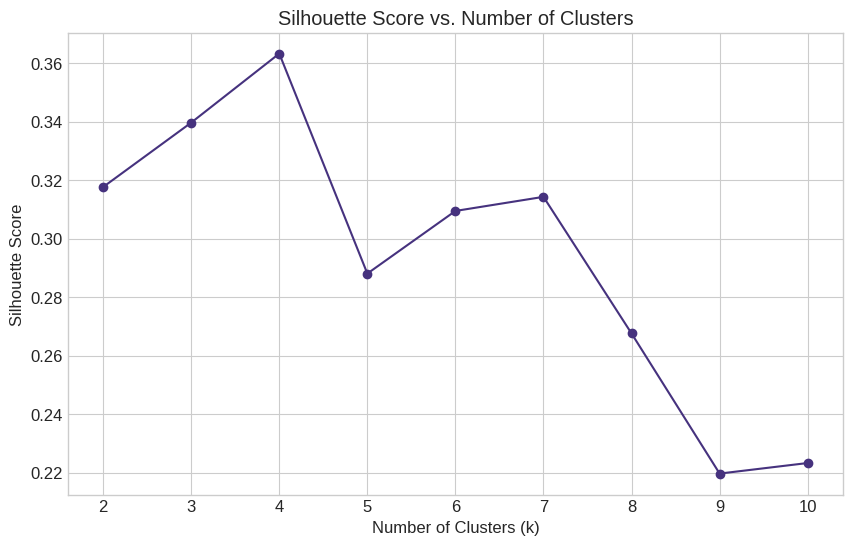


# Plotting dendrogram for hierarchical clustering


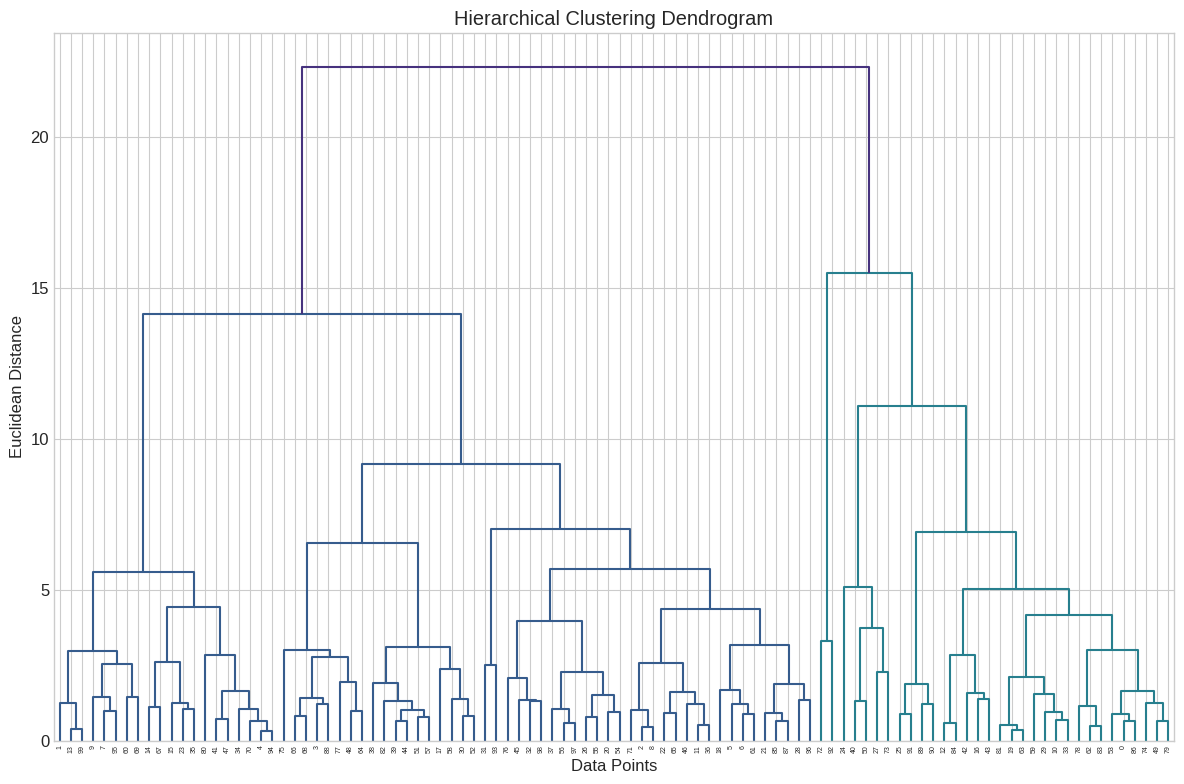


# K-Means Clustering


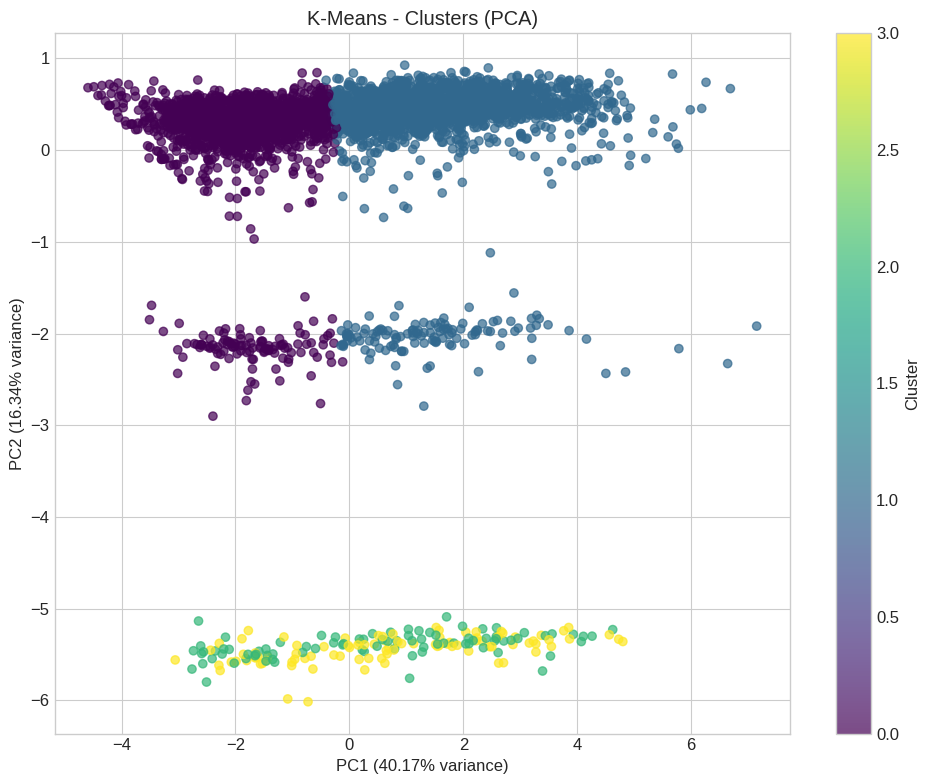

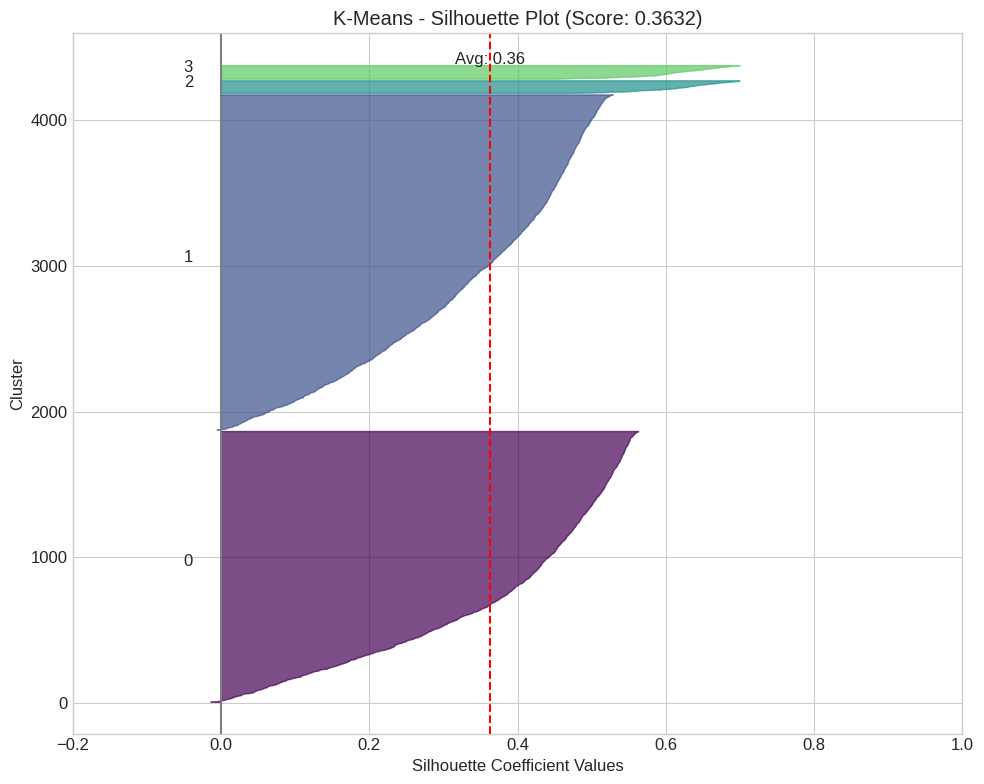

Number of clusters: 4
Silhouette Score: 0.3632
Davies-Bouldin Index: 0.8397
Calinski-Harabasz Score: 1578.2381

# Agglomerative Clustering


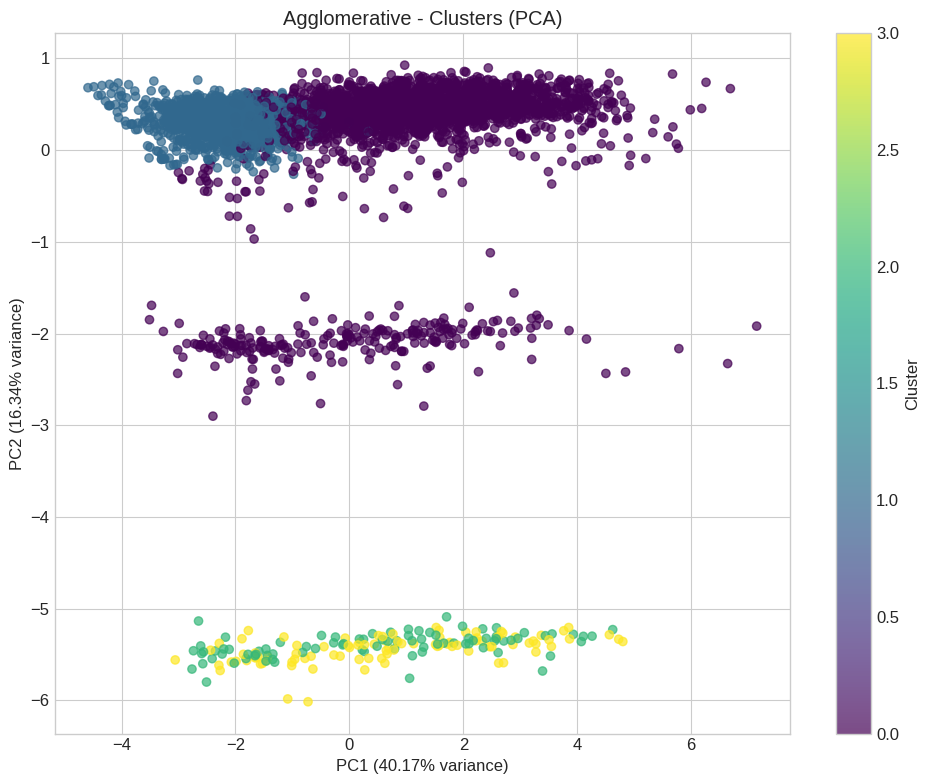

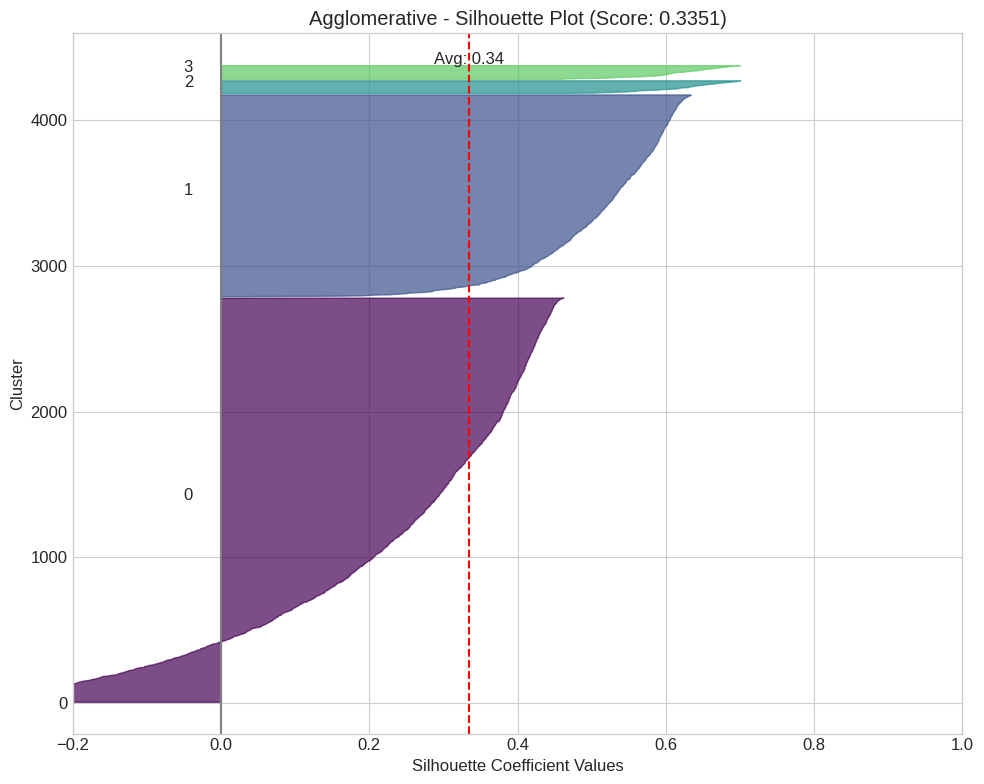

Number of clusters: 4
Silhouette Score: 0.3351
Davies-Bouldin Index: 0.8555
Calinski-Harabasz Score: 1327.6052

# DBSCAN Clustering


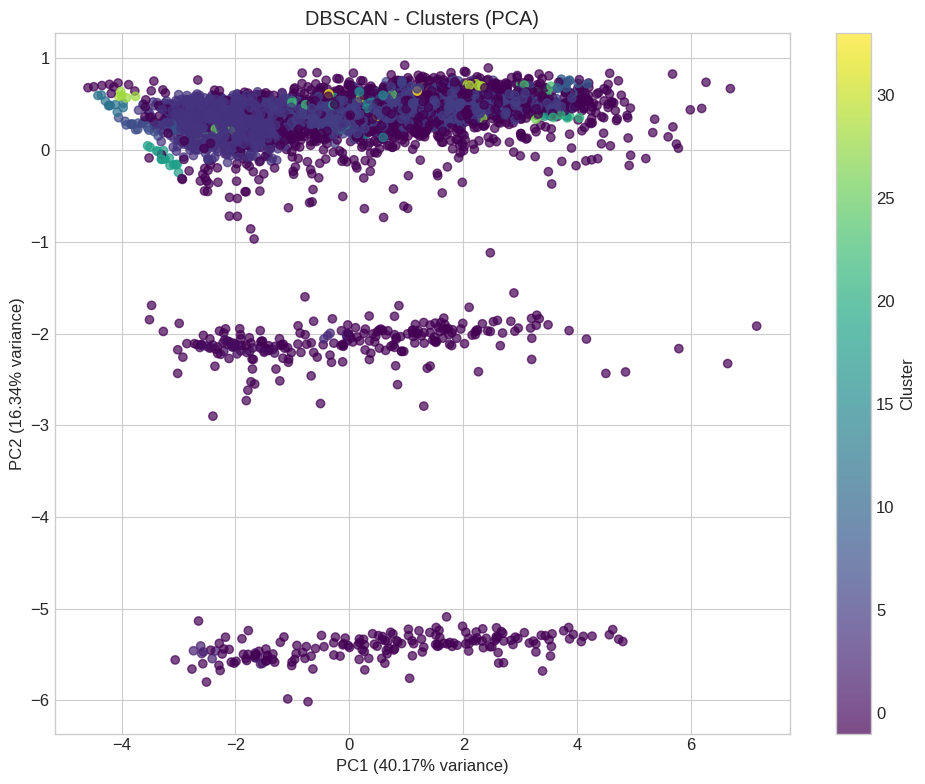

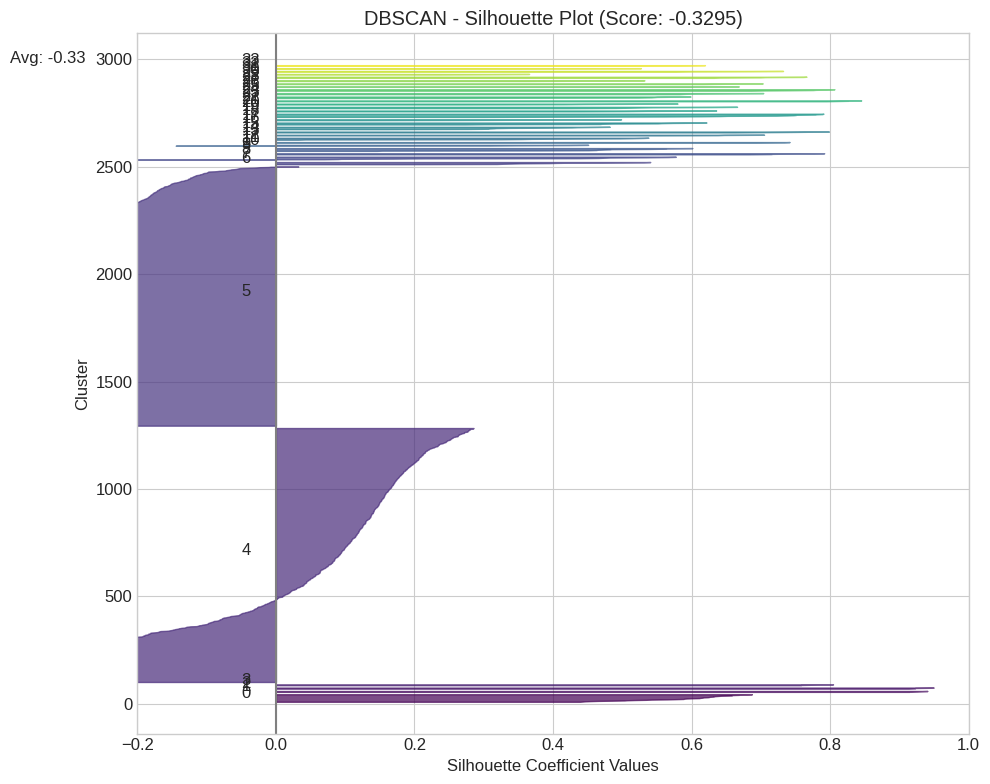

Number of clusters: 34
Silhouette Score: -0.3295
Davies-Bouldin Index: 1.5468
Calinski-Harabasz Score: 51.9041

# GaussianMixture Clustering


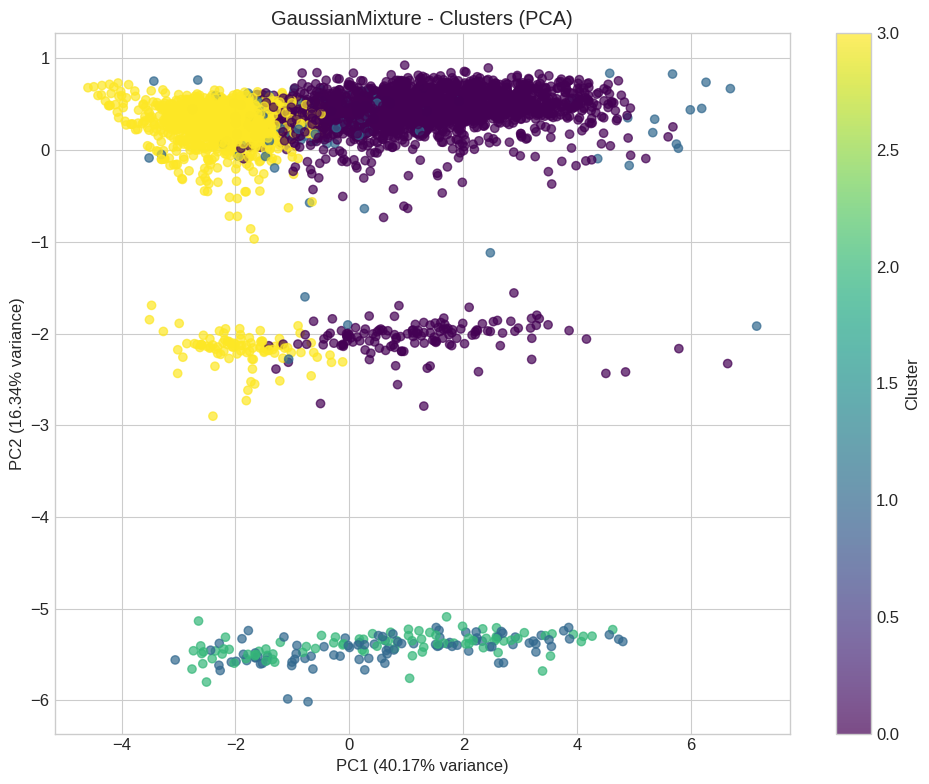

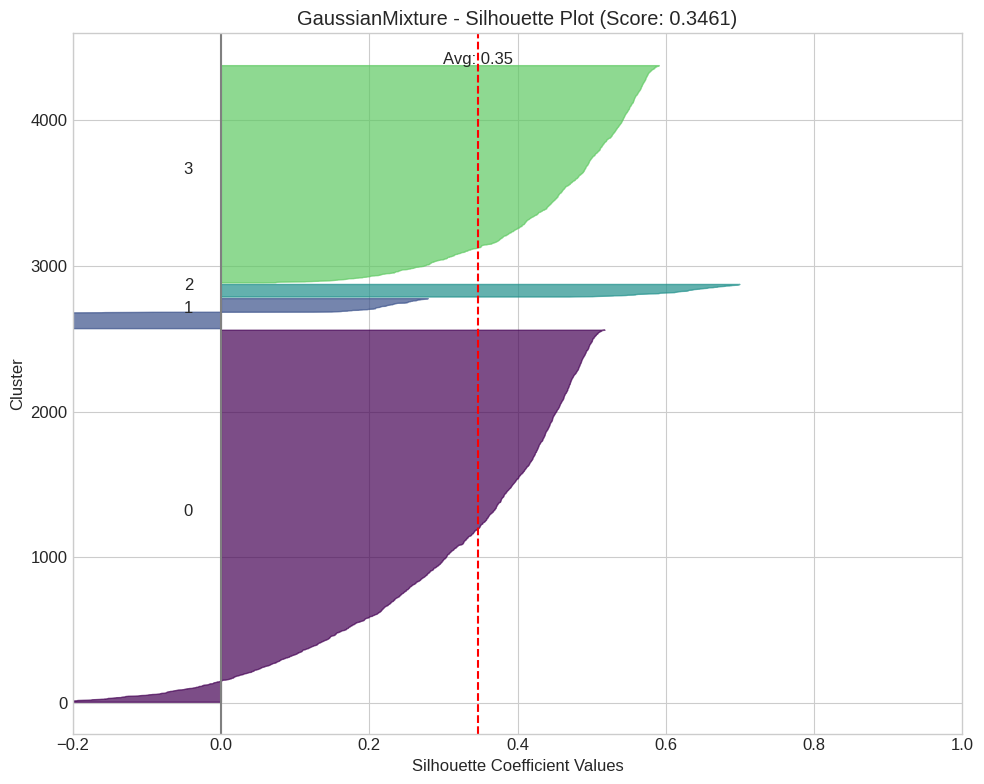

Number of clusters: 4
Silhouette Score: 0.3461
Davies-Bouldin Index: 1.5689
Calinski-Harabasz Score: 1128.1626

# SpectralClustering Clustering


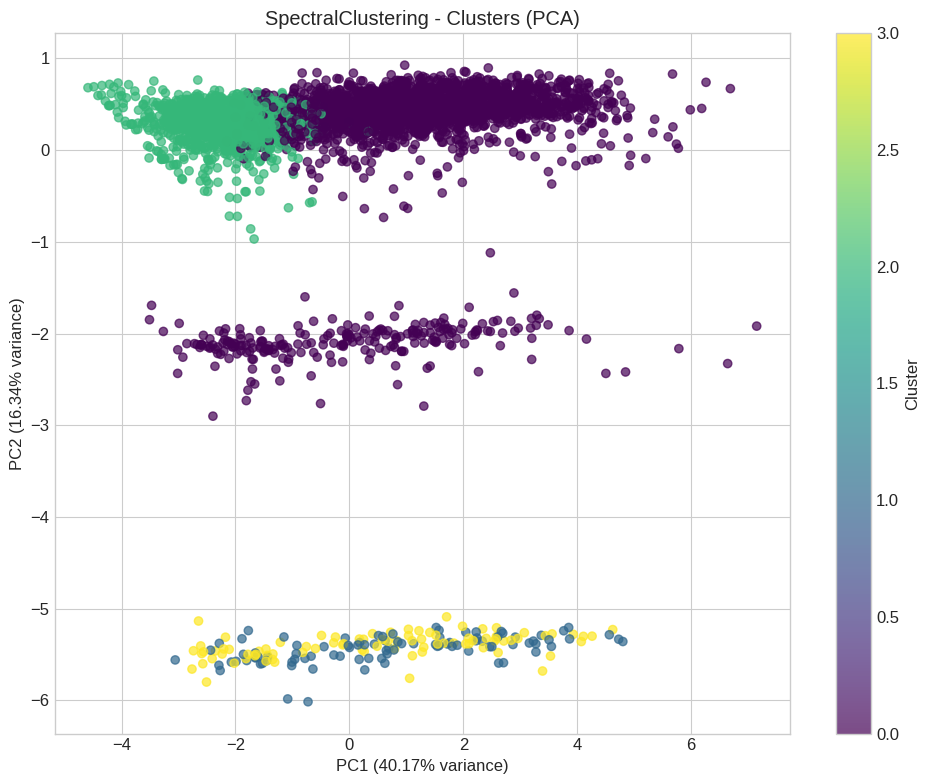

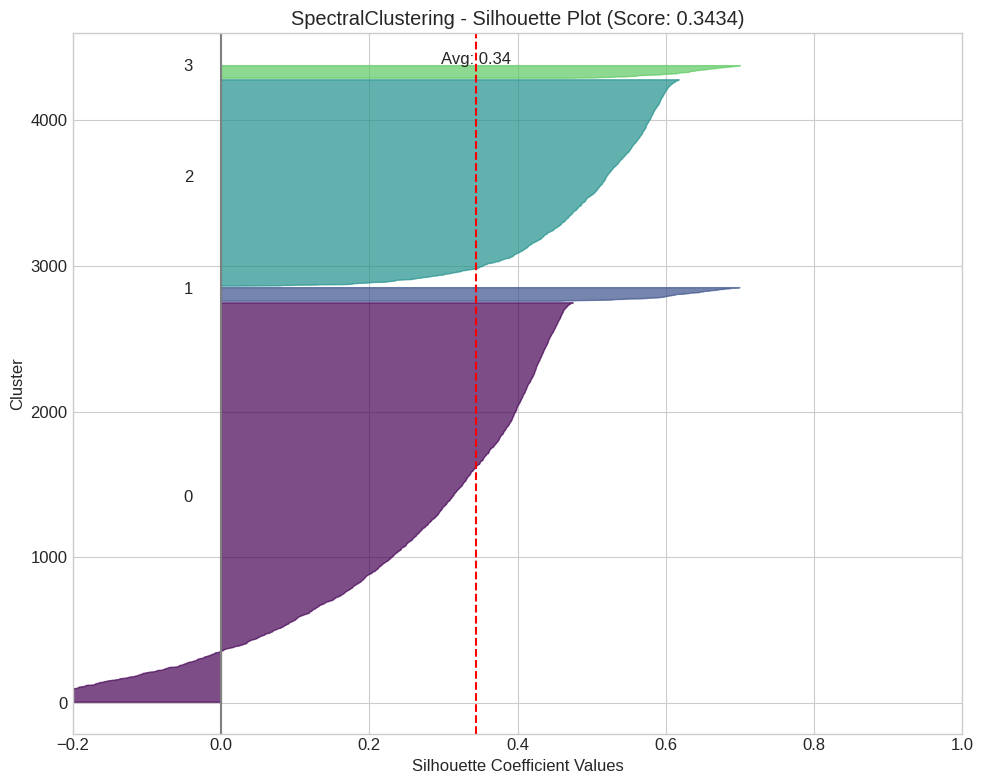

Number of clusters: 4
Silhouette Score: 0.3434
Davies-Bouldin Index: 0.8513
Calinski-Harabasz Score: 1367.8791


In [6]:
# Function to determine the optimal number of clusters using silhouette score
def optimal_k_silhouette(X, max_k=10):
    """
    Determine optimal k using silhouette score
    """
    silhouette_scores = []

    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append((k, score))
        print(f"K = {k}, Silhouette Score = {score:.4f}")

    optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k+1), [score for _, score in silhouette_scores], marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.grid(True)
    plt.show()

    return optimal_k

# Function to visualize clusters in 2D using PCA
def plot_clusters_pca(X, labels, title):
    """
    Visualize clusters using PCA for dimensionality reduction
    """
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title(f'{title} - Clusters (PCA)')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.tight_layout()
    plt.show()

    return components

# Function to plot silhouette plot
def plot_silhouette(X, labels, title):
    """
    Create a silhouette plot for cluster visualization
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    plt.figure(figsize=(10, 8))

    # Silhouette coefficient for each sample
    silhouette_values = silhouette_samples(X, labels)

    y_lower = 10

    for i in range(n_clusters):
        if i == -1:  # Skip noise if present (DBSCAN)
            continue

        ith_cluster_silhouette_values = silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.viridis(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    # Get the average silhouette score
    avg_silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 and len(set(labels)) < len(X) else 0

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=avg_silhouette, color="red", linestyle="--")
    plt.text(avg_silhouette, y_lower, f"Avg: {avg_silhouette:.2f}",
             horizontalalignment="center")

    plt.title(f"{title} - Silhouette Plot (Score: {avg_silhouette:.4f})")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")

    # The vertical line for silhouette score = 0
    plt.axvline(x=0, color="gray", linestyle="-")

    plt.xlim([-0.2, 1])
    plt.tight_layout()
    plt.show()

# Function to create dendrogram for hierarchical clustering
def plot_dendrogram(X, max_samples=100):
    """
    Plot dendrogram for hierarchical clustering visualization
    """
    # Sample data if too large
    if X.shape[0] > max_samples:
        indices = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sample = X[indices]
    else:
        X_sample = X

    plt.figure(figsize=(12, 8))

    # Create linkage matrix
    linked = sch.linkage(X_sample, method='ward')

    # Plot dendrogram
    sch.dendrogram(linked)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Data Points')
    plt.ylabel('Euclidean Distance')
    plt.tight_layout()
    plt.show()

# Function to evaluate clustering models
def evaluate_clustering(X, labels, model_name):
    """
    Evaluate clustering using multiple metrics
    """
    # Skip evaluation if all samples are considered noise (-1) or only one cluster
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or (len(unique_labels) == 2 and -1 in unique_labels):
        print(f"{model_name}: Invalid clustering result - all points might be considered noise or only one cluster")
        return None

    # Calculate metrics
    try:
        sil_score = silhouette_score(X, labels)
    except:
        sil_score = None

    try:
        db_score = davies_bouldin_score(X, labels)
    except:
        db_score = None

    try:
        ch_score = calinski_harabasz_score(X, labels)
    except:
        ch_score = None

    result = {
        'model': model_name,
        'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
        'silhouette': sil_score,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score
    }

    return result

# Determine optimal number of clusters
print("\n# Finding optimal number of clusters")
optimal_k = optimal_k_silhouette(X_scaled, max_k=10)

# Plot dendrogram for hierarchical clustering
print("\n# Plotting dendrogram for hierarchical clustering")
plot_dendrogram(X_scaled)

# Initialize models
models = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=optimal_k),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'GaussianMixture': GaussianMixture(n_components=optimal_k, random_state=42),
    'SpectralClustering': SpectralClustering(n_clusters=optimal_k, random_state=42, affinity='nearest_neighbors')
}

# Fit models and evaluate
results = []

for name, model in models.items():
    print(f"\n# {name} Clustering")

    # Fit the model
    labels = model.fit_predict(X_scaled)

    # Plot clusters
    plot_clusters_pca(X_scaled, labels, name)

    # Plot silhouette
    try:
        plot_silhouette(X_scaled, labels, name)
    except:
        print(f"Could not generate silhouette plot for {name}")

    # Evaluate
    eval_result = evaluate_clustering(X_scaled, labels, name)
    if eval_result:
        results.append(eval_result)
        print(f"Number of clusters: {eval_result['n_clusters']}")
        print(f"Silhouette Score: {eval_result['silhouette']:.4f}")
        print(f"Davies-Bouldin Index: {eval_result['davies_bouldin']:.4f}")
        print(f"Calinski-Harabasz Score: {eval_result['calinski_harabasz']:.4f}")

# Membandingkan model dengan matriks evaluasi

## Matriks evaluasi
1. Silhouette Score
2. Davies-Bouldin Index
3. Calinski-Harabasz Score

In [7]:
results_df = pd.DataFrame(results)

# Sort by silhouette score (higher is better)
print("\nSorted by Silhouette Score (higher is better):")
print(results_df.sort_values('silhouette', ascending=False))

# Sort by Davies-Bouldin index (lower is better)
print("\nSorted by Davies-Bouldin Index (lower is better):")
print(results_df.sort_values('davies_bouldin'))

# Sort by Calinski-Harabasz score (higher is better)
print("\nSorted by Calinski-Harabasz Score (higher is better):")
print(results_df.sort_values('calinski_harabasz', ascending=False))

# Find the best model based on average ranking across metrics
results_df['rank_silhouette'] = results_df['silhouette'].rank(ascending=False)
results_df['rank_davies_bouldin'] = results_df['davies_bouldin'].rank(ascending=True)
results_df['rank_calinski_harabasz'] = results_df['calinski_harabasz'].rank(ascending=False)
results_df['avg_rank'] = results_df[['rank_silhouette', 'rank_davies_bouldin', 'rank_calinski_harabasz']].mean(axis=1)

print("\nOverall Rankings (average rank across all metrics):")
print(results_df.sort_values('avg_rank')[['model', 'n_clusters', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'avg_rank']])

best_model = results_df.loc[results_df['avg_rank'].idxmin(), 'model']
print(f"\nBest overall model: {best_model}")


Sorted by Silhouette Score (higher is better):
                model  n_clusters  silhouette  davies_bouldin  \
0             K-Means           4    0.363248        0.839743   
3     GaussianMixture           4    0.346074        1.568867   
4  SpectralClustering           4    0.343412        0.851255   
1       Agglomerative           4    0.335065        0.855538   
2              DBSCAN          34   -0.329451        1.546793   

   calinski_harabasz  
0        1578.238109  
3        1128.162592  
4        1367.879092  
1        1327.605189  
2          51.904121  

Sorted by Davies-Bouldin Index (lower is better):
                model  n_clusters  silhouette  davies_bouldin  \
0             K-Means           4    0.363248        0.839743   
4  SpectralClustering           4    0.343412        0.851255   
1       Agglomerative           4    0.335065        0.855538   
2              DBSCAN          34   -0.329451        1.546793   
3     GaussianMixture           4    0.346074  

### Analisis model terbaik


Cluster Analysis:
        total_orders        unique_products        total_quantity         \
                mean median            mean median           mean median   
Cluster                                                                    
0           1.298708    1.0       21.853068   16.0     272.849300  152.0   
1           6.643323    4.0       93.147455   66.0    1926.979556  819.0   
2           4.471264    3.0       64.793103   38.0    1281.275862  445.0   
3           4.861702    3.0       68.148936   38.5    1268.734043  609.0   

        total_spending          avg_spending_per_order             \
                  mean   median                   mean     median   
Cluster                                                             
0           463.184285   296.67              87.784255  17.564722   
1          3311.405095  1388.37              55.986507  17.712121   
2          2402.575287   862.81              23.075504  19.460566   
3          2434.756809  1066.14   

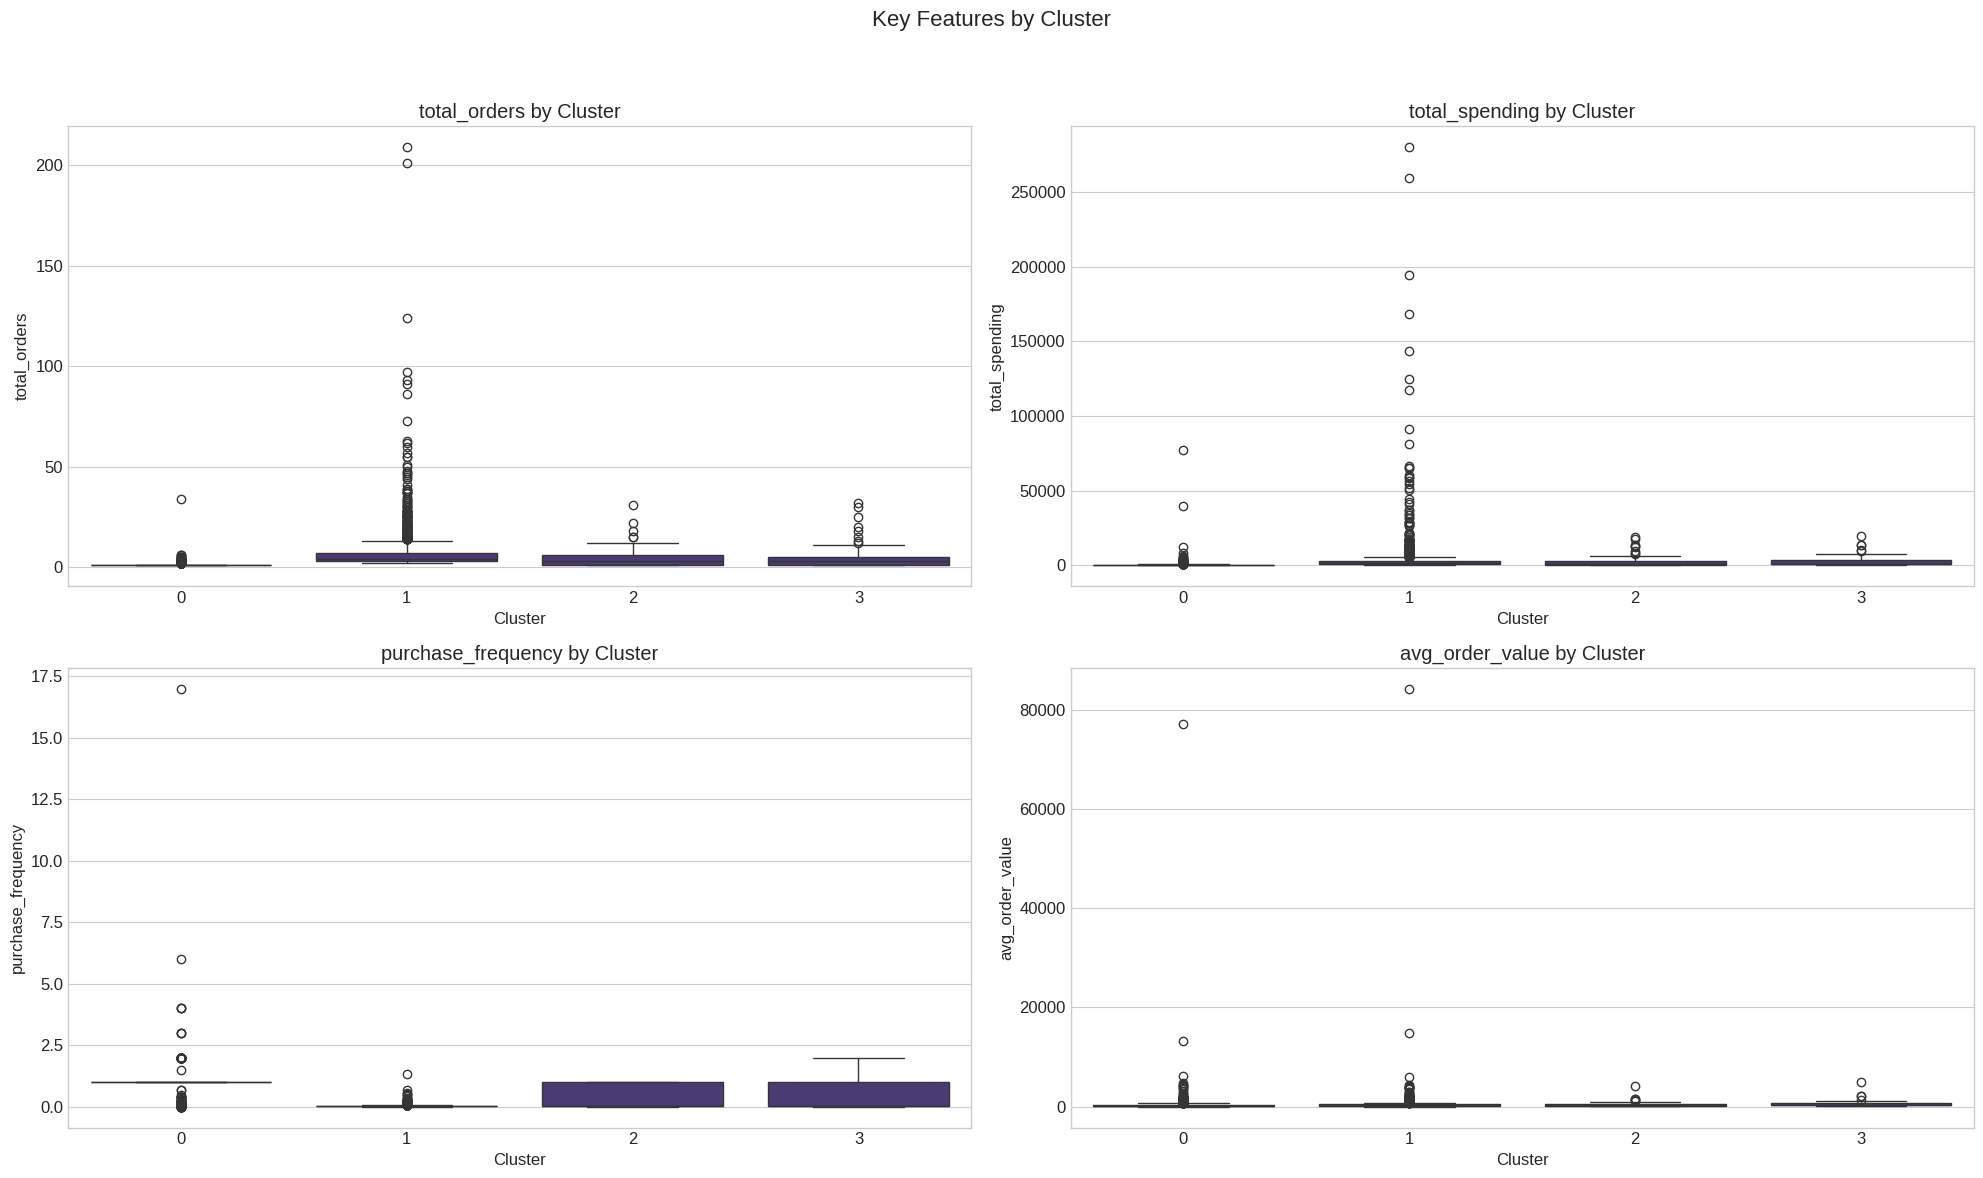

In [8]:
# Get the best model
best_model_instance = models[best_model]

# Get labels from the best model
if hasattr(best_model_instance, 'labels_'):
    best_labels = best_model_instance.labels_
else:
    best_labels = best_model_instance.fit_predict(X_scaled)

# Add cluster labels to the original customer features
customer_features['Cluster'] = best_labels

# Analyze clusters
cluster_analysis = customer_features.groupby('Cluster').agg({
    'total_orders': ['mean', 'median'],
    'unique_products': ['mean', 'median'],
    'total_quantity': ['mean', 'median'],
    'total_spending': ['mean', 'median'],
    'avg_spending_per_order': ['mean', 'median'],
    'days_since_last_purchase': ['mean', 'median'],
    'customer_lifetime': ['mean', 'median'],
    'purchase_frequency': ['mean', 'median'],
    'avg_order_value': ['mean', 'median']
})

print("\nCluster Analysis:")
print(cluster_analysis)

# Visualize cluster characteristics
plt.figure(figsize=(20, 12))

# Select key features for visualization
key_features = ['total_orders', 'total_spending', 'purchase_frequency', 'avg_order_value']

for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=customer_features)
    plt.title(f'{feature} by Cluster')
    plt.tight_layout()

plt.suptitle('Key Features by Cluster', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Interpretasi Customer Segment


Cluster 0 - 1858 customers (42.8%)
Average Values:
  Total Orders: 1.30
  Total Spending: $463.18
  Average Order Value: $380.05
  Purchase Frequency: 0.8733 orders/day
  Days Since Last Purchase: 153.5
  Customer Lifetime: 13.6 days
Top Countries:
  United Kingdom: 1746 customers (94.0%)
  Spain: 12 customers (0.6%)
  Switzerland: 10 customers (0.5%)
  Italy: 9 customers (0.5%)
  Portugal: 9 customers (0.5%)

Cluster 1 - 2299 customers (53.0%)
Average Values:
  Total Orders: 6.64
  Total Spending: $3311.41
  Average Order Value: $444.01
  Purchase Frequency: 0.0349 orders/day
  Days Since Last Purchase: 42.2
  Customer Lifetime: 224.0 days
Top Countries:
  United Kingdom: 2174 customers (94.6%)
  Belgium: 19 customers (0.8%)
  Spain: 18 customers (0.8%)
  Switzerland: 11 customers (0.5%)
  Portugal: 10 customers (0.4%)

Cluster 2 - 87 customers (2.0%)
Average Values:
  Total Orders: 4.47
  Total Spending: $2402.58
  Average Order Value: $464.41
  Purchase Frequency: 0.3528 orders/day

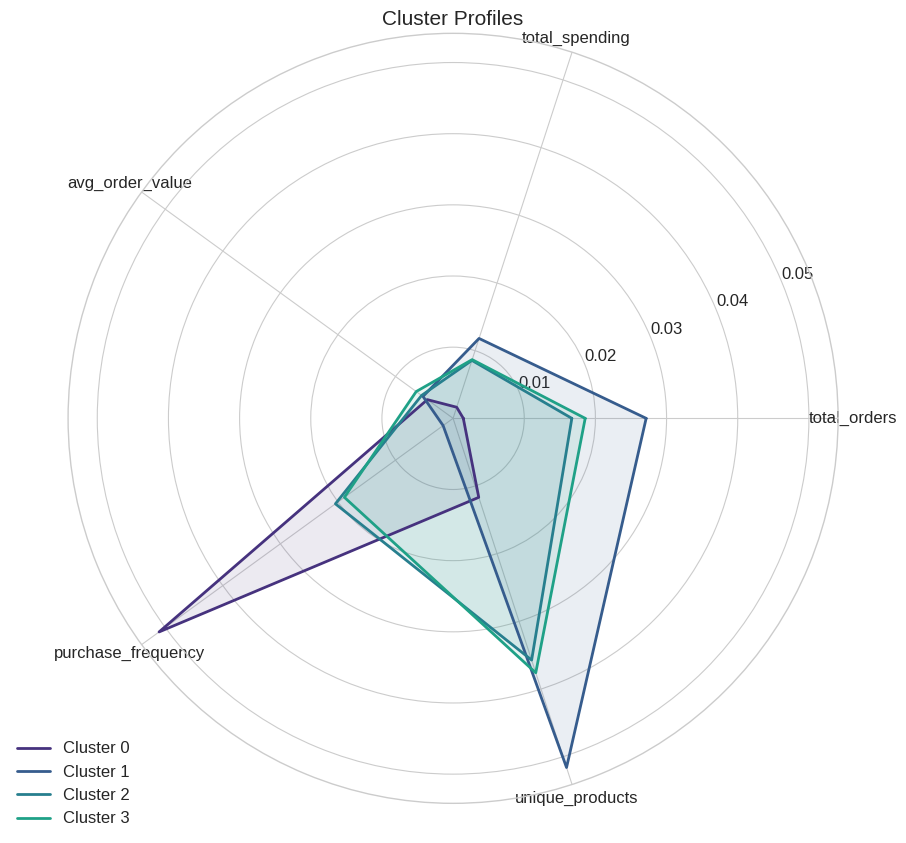

In [9]:
# Analyze each cluster and provide interpretation
for cluster in sorted(customer_features['Cluster'].unique()):
    cluster_data = customer_features[customer_features['Cluster'] == cluster]

    print(f"\nCluster {cluster} - {len(cluster_data)} customers ({len(cluster_data) / len(customer_features) * 100:.1f}%)")

    # Calculate mean values for key metrics
    print("Average Values:")
    print(f"  Total Orders: {cluster_data['total_orders'].mean():.2f}")
    print(f"  Total Spending: ${cluster_data['total_spending'].mean():.2f}")
    print(f"  Average Order Value: ${cluster_data['avg_order_value'].mean():.2f}")
    print(f"  Purchase Frequency: {cluster_data['purchase_frequency'].mean():.4f} orders/day")
    print(f"  Days Since Last Purchase: {cluster_data['days_since_last_purchase'].mean():.1f}")
    print(f"  Customer Lifetime: {cluster_data['customer_lifetime'].mean():.1f} days")

    # Top countries
    country_cols = [col for col in cluster_data.columns if col.startswith('country_')]
    country_totals = cluster_data[country_cols].sum().sort_values(ascending=False)
    if len(country_totals) > 0:
        print("Top Countries:")
        for country_col, count in country_totals[:5].items():
            country_name = country_col.replace('country_', '')
            print(f"  {country_name}: {count} customers ({count/len(cluster_data)*100:.1f}%)")

# Visualization of clusters using radar chart for key metrics
def plot_radar_chart(cluster_data, feature_cols):
    """
    Create a radar chart to visualize cluster profiles
    """
    # Number of variables
    categories = feature_cols
    N = len(categories)

    # Calculate mean for each feature for each cluster
    cluster_means = []
    for cluster in sorted(cluster_data['Cluster'].unique()):
        means = cluster_data[cluster_data['Cluster'] == cluster][feature_cols].mean().values.tolist()
        cluster_means.append(means)

    # Create angle for each feature
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)

    # Draw the cluster lines
    for i, means in enumerate(cluster_means):
        means += means[:1]  # Close the loop
        ax.plot(angles, means, linewidth=2, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles, means, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Cluster Profiles', size=15)
    plt.show()

# Normalize key features for radar chart
radar_features = ['total_orders', 'total_spending', 'avg_order_value',
                  'purchase_frequency', 'unique_products']

# Create a copy with normalized features
radar_data = customer_features.copy()
for feature in radar_features:
    radar_data[feature] = (radar_data[feature] - radar_data[feature].min()) / (radar_data[feature].max() - radar_data[feature].min())

# Plot radar chart
plot_radar_chart(radar_data, radar_features)

# Konklusi
Model terbaik adalah K-Means dengan 4 clusters.
- Silhouette Score: 0.3632
- Davies-Bouldin Index: 0.8397
- Calinski-Harabasz Score: 1578.2381

#### Perbandingan model:
1. K-Means: 4 clusters, Silhouette=0.3632, DB=0.8397, CH=1578.2381
2. SpectralClustering: 4 clusters, Silhouette=0.3434, DB=0.8513, CH=1367.8791
3. Agglomerative: 4 clusters, Silhouette=0.3351, DB=0.8555, CH=1327.6052
4. GaussianMixture: 4 clusters, Silhouette=0.3461, DB=1.5689, CH=1128.1626
5. DBSCAN: 34 clusters, Silhouette=-0.3295, DB=1.5468, CH=51.9041

# Analisa
### 1. Ketika K-Means menghasilkan silhouette score rendah (0.3) meskipun elbow method menunjukkan K=5 sebagai optimal, beberapa faktor dapat menyebabkan inkonsistensi ini:
- Distribusi data non-spherical: K-Means mengasumsikan cluster berbentuk bola (spherical) dengan ukuran yang relatif sama. Data retail sering memiliki distribusi yang tidak beraturan.
- Overlapping clusters: Data pelanggan retail sering memiliki area yang tumpang tindih antara segmen.
- Outliers: Data retail biasanya memiliki outlier signifikan (seperti pelanggan dengan pembelian sangat besar).

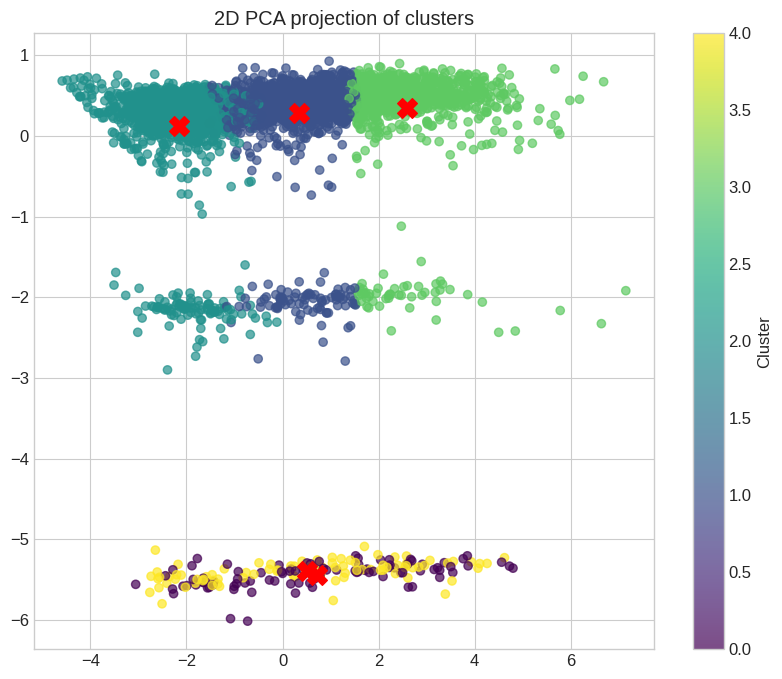

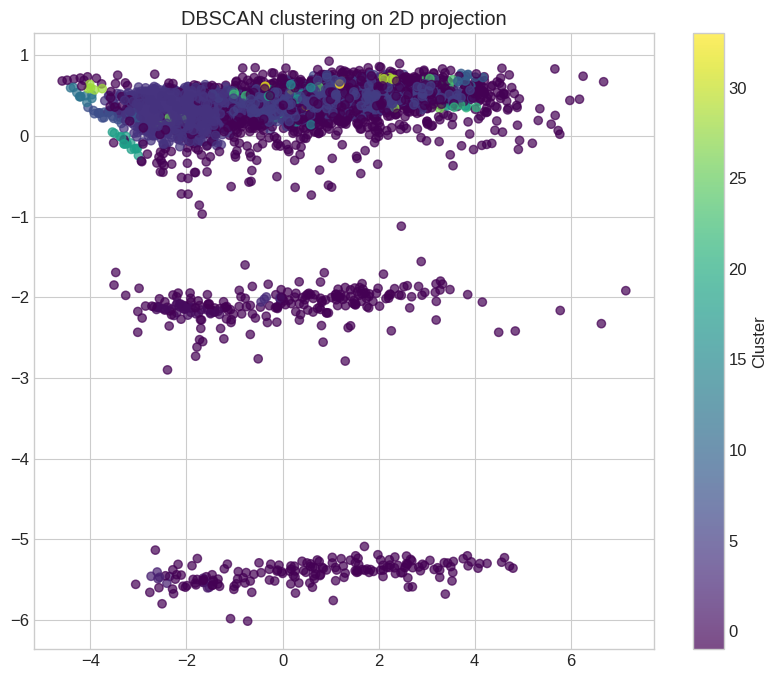

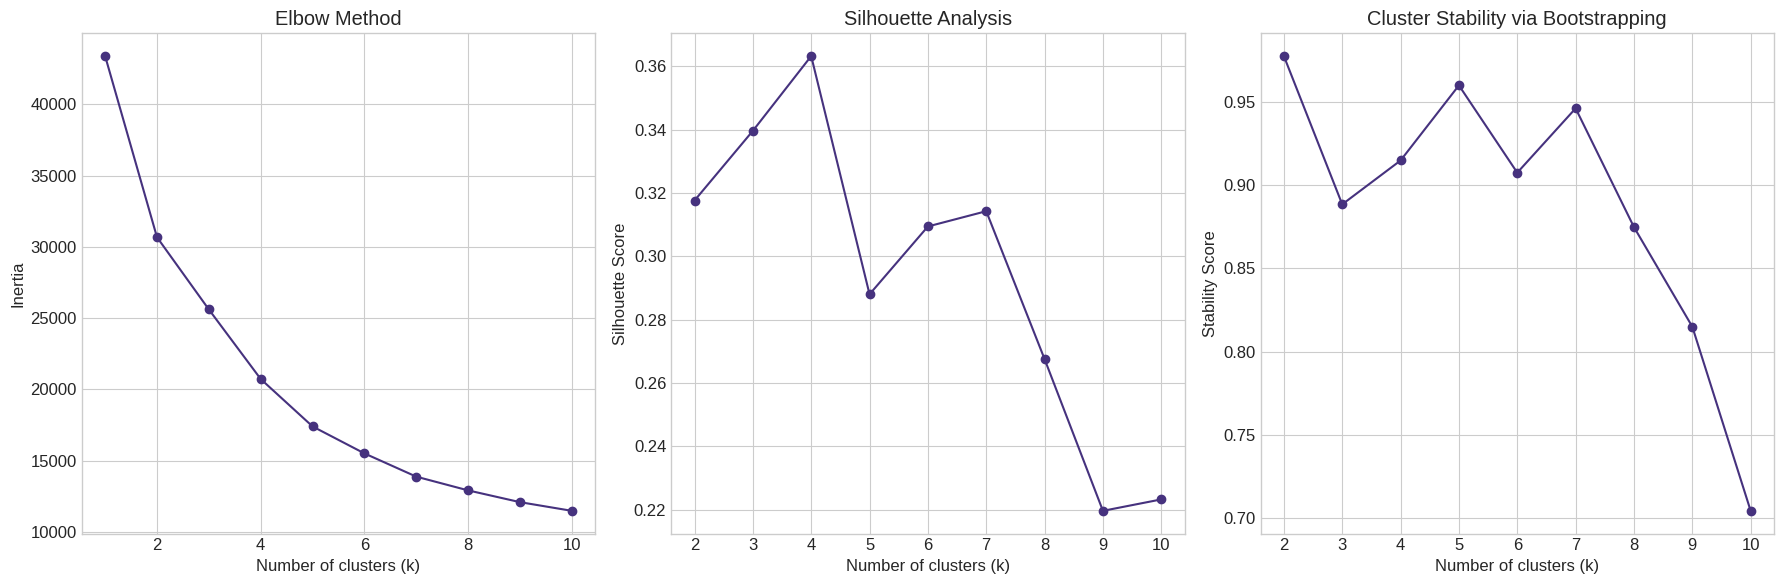

{'elbow_k': np.int64(1), 'silhouette_k': np.int64(4), 'gap_k': 10, 'stability_k': np.int64(2)}


In [10]:
# import optimalK
import requests

# URL of the file
url = "https://raw.githubusercontent.com/milesgranger/gap_statistic/master/gap_statistic/optimalK.py"

# Download the file
response = requests.get(url)

# Save the file
with open("optimalK.py", "wb") as file:
    file.write(response.content)

from optimalK import OptimalK


# Analisis validasi alternatif
def validate_clusters(X, max_k=10):
    # 1. Gap Statistic
    optimalK = OptimalK()
    gap_k = optimalK(X, cluster_array=range(1, max_k+1))

    # 2. Bootstrapping untuk stabilitas cluster
    stability_scores = []
    n_bootstraps = 30
    sample_size = int(0.8 * X.shape[0])

    for k in range(2, max_k+1):
        agreement_scores = []

        # Original clustering
        kmeans_orig = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_orig = kmeans_orig.fit_predict(X)

        for i in range(n_bootstraps):
            # Bootstrap sample
            indices = np.random.choice(X.shape[0], sample_size, replace=True)
            X_sample = X[indices]

            # Fit model on bootstrap sample
            kmeans_boot = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans_boot.fit(X_sample)

            # Predict on original data
            labels_boot = kmeans_boot.predict(X)

            # Calculate agreement (using adjusted Rand index)
            from sklearn.metrics import adjusted_rand_score
            agreement = adjusted_rand_score(labels_orig, labels_boot)
            agreement_scores.append(agreement)

        stability_scores.append(np.mean(agreement_scores))

    # Plot results
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Elbow Method
    inertia = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    ax[0].plot(range(1, max_k+1), inertia, 'o-')
    ax[0].set_xlabel('Number of clusters (k)')
    ax[0].set_ylabel('Inertia')
    ax[0].set_title('Elbow Method')

    # Silhouette Score
    sil_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        sil_scores.append(score)

    ax[1].plot(range(2, max_k+1), sil_scores, 'o-')
    ax[1].set_xlabel('Number of clusters (k)')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].set_title('Silhouette Analysis')

    # Stability Score
    ax[2].plot(range(2, max_k+1), stability_scores, 'o-')
    ax[2].set_xlabel('Number of clusters (k)')
    ax[2].set_ylabel('Stability Score')
    ax[2].set_title('Cluster Stability via Bootstrapping')

    plt.tight_layout()
    plt.show()

    return {
        'elbow_k': np.argmin(np.diff(inertia)) + 1,
        'silhouette_k': np.argmax(sil_scores) + 2,
        'gap_k': gap_k,
        'stability_k': np.argmax(stability_scores) + 2
    }

# Untuk melihat apakah data non-spherical
def check_non_spherical(X):
    from sklearn.decomposition import PCA

    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Fit KMeans with k=5
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    centers_2d = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=200, marker='X')

    plt.title('2D PCA projection of clusters')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

    # Try a non K-means clustering approach for comparison
    from sklearn.cluster import DBSCAN

    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
    plt.title('DBSCAN clustering on 2D projection')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

check_non_spherical(X_scaled)
results = validate_clusters(X_scaled)
print(results)

### 2. Preprocessing untuk Campuran Fitur Numerik dan Kategorikal
Untuk dataset dengan campuran fitur numerik (Quantity, UnitPrice) dan kategorikal high-cardinality (Description), berikut metode preprocessing yang efektif:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import umap

# Fungsi preprocessing untuk campuran fitur
def preprocess_mixed_features(df, numeric_cols, text_cols, categorical_cols=None):
    """
    Preprocess mixed feature types for clustering
    """
    result_dfs = []

    # 1. Numeric features - standardize
    if numeric_cols:
        numeric_df = df[numeric_cols].copy()
        # Handle missing values
        numeric_df.fillna(numeric_df.median(), inplace=True)
        # Scale features
        scaler = StandardScaler()
        scaled_numeric = scaler.fit_transform(numeric_df)
        numeric_result = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=df.index)
        result_dfs.append(numeric_result)

    # 2. Text features - TF-IDF + dimensionality reduction
    if text_cols:
        for col in text_cols:
            # Fill missing values
            df[col].fillna("unknown", inplace=True)

            # Create TF-IDF vectors
            tfidf = TfidfVectorizer(
                min_df=5,            # Minimum document frequency
                max_features=1000,   # Limit vocabulary size
                stop_words='english' # Remove common words
            )
            text_tfidf = tfidf.fit_transform(df[col].astype(str))

            # Reduce dimensions with TruncatedSVD (similar to PCA but works on sparse matrices)
            svd = TruncatedSVD(n_components=min(10, text_tfidf.shape[1] - 1))
            text_reduced = svd.fit_transform(text_tfidf)

            # Create DataFrame with reduced features
            text_result = pd.DataFrame(
                text_reduced,
                columns=[f"{col}_tfidf_{i}" for i in range(text_reduced.shape[1])],
                index=df.index
            )
            result_dfs.append(text_result)

            # Alternative: Use UMAP for lower-dimensional embedding
            try:
                reducer = umap.UMAP(n_components=5, metric='cosine', random_state=42)
                text_umap = reducer.fit_transform(text_tfidf.toarray())
                text_umap_df = pd.DataFrame(
                    text_umap,
                    columns=[f"{col}_umap_{i}" for i in range(text_umap.shape[1])],
                    index=df.index
                )
                result_dfs.append(text_umap_df)
            except:
                print(f"UMAP reduction failed for {col}, skipping...")

    # 3. Categorical features - Binary encoding or Target encoding
    if categorical_cols:
        for col in categorical_cols:
            if df[col].nunique() < 20:  # Low cardinality
                # One-hot encoding for low cardinality
                dummies = pd.get_dummies(df[col], prefix=col)
                result_dfs.append(dummies)
            else:  # High cardinality
                # Target encoding example (assuming we have a target variable)
                # For clustering, we can use frequency encoding
                freq_encoding = df.groupby(col).size() / len(df)
                df[f"{col}_freq"] = df[col].map(freq_encoding)
                result_dfs.append(pd.DataFrame(df[f"{col}_freq"]))

    # Combine all processed features
    processed_df = pd.concat(result_dfs, axis=1)
    return processed_df

# Contoh penggunaan:
# processed_data = preprocess_mixed_features(
#     df,
#     numeric_cols=['Quantity', 'UnitPrice', 'TotalAmount'],
#     text_cols=['Description'],
#     categorical_cols=['Country']
# )

Risiko menggunakan One-Hot Encoding untuk Description:

1. Dimensi terlalu tinggi: Karena Description mungkin memiliki ribuan nilai unik, one-hot encoding akan menghasilkan matriks sangat besar dan sparse.
2. Curse of dimensionality: Terlalu banyak dimensi akan membuat jarak antar titik menjadi kurang bermakna untuk clustering.
3. Komputasi berat: Memori dan waktu komputasi meningkat drastis.
4. Tidak menangkap semantik: Tidak menangkap kemiripan antara deskripsi-deskripsi yang terkait.

Teknik seperti TF-IDF atau embedding berdimensi rendah lebih robust karena:

1. TF-IDF: Menangkap pentingnya kata dalam konteks dokumen, memberi bobot yang tepat pada kata-kata kunci.
2. Dimensi rendah (UMAP/SVD): Mempertahankan informasi semantik penting sambil mengurangi dimensi secara signifikan.
3. Mempertahankan struktur semantik: Deskripsi produk yang serupa akan memiliki representasi vektor yang dekat dalam ruang embedding.
4. Efisiensi komputasi: Mengurangi jumlah fitur drastis tanpa kehilangan informasi penting.

### 3. Penentuan Parameter Optimal untuk DBSCAN
Menentukan parameter optimal epsilon secara adaptif untuk DBSCAN pada data transaksi yang tidak seimbang:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

def find_optimal_dbscan_params(X, k_dist=5, regional_density=True):
    # Calculate k-distance graph
    neigh = NearestNeighbors(n_neighbors=k_dist)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)

    # Sort distances to k-th nearest neighbor
    k_dist = np.sort(distances[:, k_dist-1])

    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_dist)), k_dist)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'Distance to {k_dist}-th nearest neighbor')
    plt.title('k-distance Graph')

    # Find elbow point (where the curve shows significant change)
    from kneed import KneeLocator
    try:
        knee_locator = KneeLocator(range(len(k_dist)), k_dist,
                                 curve='convex', direction='increasing')
        knee_point = knee_locator.knee
        epsilon = k_dist[knee_point]
        plt.axvline(x=knee_point, color='r', linestyle='--')
        plt.axhline(y=epsilon, color='g', linestyle='--')
        plt.text(knee_point + len(k_dist)*0.01, epsilon, f'Knee point: epsilon ≈ {epsilon:.3f}')
    except:
        # Fallback if knee detection fails
        epsilon = np.percentile(k_dist, 90)  # Use 90th percentile as default
        plt.axhline(y=epsilon, color='g', linestyle='--')
        plt.text(len(k_dist)*0.7, epsilon, f'90th percentile: epsilon ≈ {epsilon:.3f}')

    plt.show()

    # Calculate third quartile as alternative
    q3_epsilon = np.percentile(k_dist, 75)
    print(f"Third quartile epsilon value: {q3_epsilon:.3f}")

    # Adaptive MinPts calculation based on regional density
    if regional_density:
        # Divide data into regions (using simple approach with quantiles)
        from sklearn.cluster import KMeans

        # Use a simple KMeans to identify potential regions
        n_regions = min(5, X.shape[0] // 100)  # Adjust based on data size
        kmeans = KMeans(n_clusters=n_regions, random_state=42, n_init=10)
        regions = kmeans.fit_predict(X)

        # Calculate density for each region
        density_by_region = []
        min_pts_by_region = []

        for region in range(n_regions):
            region_points = X[regions == region]
            if len(region_points) < 10:  # Skip very small regions
                continue

            # Calculate average distance between points in this region
            region_neigh = NearestNeighbors(n_neighbors=min(10, len(region_points)-1))
            region_neigh.fit(region_points)
            region_distances, _ = region_neigh.kneighbors(region_points)
            avg_distance = region_distances[:, 1:].mean()  # Skip the point itself

            # Calculate density (inverse of average distance)
            density = 1 / max(avg_distance, 1e-10)  # Avoid division by zero
            density_by_region.append((region, density))

            # Suggest MinPts based on density
            suggested_min_pts = max(3, int(5 * (density / max(d for _, d in density_by_region))))
            min_pts_by_region.append((region, suggested_min_pts))

        # Print suggested MinPts for each region
        print("\nSuggested MinPts by region:")
        for region, min_pts in min_pts_by_region:
            region_size = (regions == region).sum()
            region_ratio = region_size / len(X)
            print(f"Region {region}: {min_pts} MinPts (contains {region_size} points, {region_ratio:.1%} of data)")

    return epsilon, q3_epsilon

# Run DBSCAN with different epsilon values
def compare_dbscan_results(X, epsilons, min_samples=5):
    plt.figure(figsize=(15, 10))

    for i, eps in enumerate(epsilons):
        # Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        # Number of clusters and noise points
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Plot
        plt.subplot(2, len(epsilons)//2 + len(epsilons)%2, i+1)

        # Reduce to 2D for visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)

        unique_labels = set(labels)
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise
                col = 'gray'

            mask = labels == k
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1], c=[col], alpha=0.8, s=10)

        plt.title(f'DBSCAN: eps={eps:.3f}\n{n_clusters} clusters, {n_noise} noise')
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

# Contoh penggunaan:
# 1. Find optimal parameters
# epsilon, q3_epsilon = find_optimal_dbscan_params(X_scaled)
#
# 2. Compare different epsilon values
# epsilons = [epsilon * 0.7, epsilon * 0.85, epsilon, epsilon * 1.15, epsilon * 1.3, q3_epsilon]
# compare_dbscan_results(X_scaled, epsilons)

Peran k-distance graph dan kuartil ke-3 dalam automasi parameter:

k-distance graph:

Mengurutkan jarak k-tetangga terdekat untuk setiap titik
Titik-titik perubahan tajam (elbow points) menunjukkan threshold densitas yang baik untuk epsilon
Visualisasi ini membantu mendeteksi nilai epsilon optimal secara empiris


Kuartil ke-3 (Q3):

Nilai epsilon berdasarkan persentil ke-75 dari distribusi k-distance
Memberikan estimasi stabil yang memastikan mayoritas titik dikelompokkan
Kurang sensitif terhadap outlier dibanding nilai maksimum atau rata-rata



MinPts harus disesuaikan berdasarkan kerapatan regional karena:

Variasi kerapatan: Pada data retail, beberapa segmen pelanggan (seperti UK) bisa jauh lebih padat
Deteksi noise yang tepat: MinPts terlalu kecil bisa menyebabkan chaining effect; terlalu besar bisa mengklasifikasikan terlalu banyak titik sebagai noise
Cluster ukuran berbeda: Menggunakan MinPts adaptif memungkinkan deteksi cluster dari berbagai ukuran dan densitas
Relevansi lokal: Memastikan parameter DBSCAN relevan untuk struktur lokal data

### 4. Mengatasi Overlap Cluster dengan Teknik Semi-supervised
Ketika terjadi overlap signifikan antara cluster "high-value customers" dan "bulk buyers", teknik semi-supervised dan metric learning dapat membantu:
Jika terjadi overlap signifikan antara cluster "high-value customers" dan "bulk buyers" berdasarkan total pengeluaran, beberapa teknik semi-supervised dan metric learning dapat memperbaiki pemisahan cluster:

#### a. Constrained Clustering (Semi-supervised)
Constrained clustering memungkinkan kita untuk memasukkan pengetahuan domain dengan menambahkan constraints:

Must-link constraints: Pasangan data points yang harus berada dalam cluster yang sama
Cannot-link constraints: Pasangan data points yang tidak boleh berada dalam cluster yang sama



In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMeansConstrained

# Contoh implementasi constrained clustering dengan sklearn_extra
def constrained_kmeans_clustering(data, high_value_indices, bulk_buyer_indices, n_clusters=5):
    # Initialize constraints
    ml_constraints = []  # Must-link constraints
    cl_constraints = []  # Cannot-link constraints

    # Tambahkan cannot-link constraints antara high-value dan bulk buyers
    for hv_idx in high_value_indices:
        for bb_idx in bulk_buyer_indices:
            cl_constraints.append((hv_idx, bb_idx))

    # Constraint matrix untuk KMeansConstrained (dalam bentuk yang lebih sederhana)
    # Pada implementasi sebenarnya, Anda perlu custom implementation atau library khusus

    # Lakukan clustering dengan constraint
    constrained_kmeans = KMeansConstrained(
        n_clusters=n_clusters,
        size_min=20,  # Minimal ukuran cluster
        random_state=42
    )
    cluster_labels = constrained_kmeans.fit_predict(data)

    return cluster_labels, constrained_kmeans

#### b. Mahalanobis Distance untuk Metric Learning
Mahalanobis distance mempertimbangkan covariance antar fitur, yang memungkinkan model untuk lebih baik menangkap struktur data yang kompleks:

In [ ]:
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def mahalanobis_clustering(data, eps=0.5, min_samples=5):
    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)

    # Compute covariance matrix
    cov = EmpiricalCovariance().fit(X_scaled)
    inv_cov = np.linalg.inv(cov.covariance_)

    # Compute pairwise Mahalanobis distances
    n_samples = X_scaled.shape[0]
    dist_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i, n_samples):
            vi = X_scaled[i]
            vj = X_scaled[j]
            dist = mahalanobis(vi, vj, inv_cov)
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    # DBSCAN with precomputed distances
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    clusters = dbscan.fit_predict(dist_matrix)

    return clusters

#### 3. Hybrid Approach dengan Semi-supervised Metric Learning


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder

def hybrid_semisupervised_clustering(data, labeled_indices, labels, n_clusters=5):
    # Encode labels untuk sampel berlabel
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    # Train a K-nearest neighbors classifier on labeled data
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(data[labeled_indices], encoded_labels)

    # Predict probabilities for all data points
    probabilities = knn.predict_proba(data)

    # Combine original features with label probabilities
    enhanced_features = np.hstack((data, probabilities))

    # Perform final clustering on enhanced features
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    final_clusters = kmeans.fit_predict(enhanced_features)

    return final_clusters

#### Tantangan dalam Mempertahankan Interpretabilitas Bisnis dengan Pendekatan Non-Euclidean
1. Kompleksitas Interpretasi: Jarak Mahalanobis atau metrik non-Euclidean lainnya sulit dijelaskan kepada stakeholder bisnis yang mungkin tidak memiliki latar belakang teknis.
2. Visualisasi yang Sulit: Metrik non-Euclidean sulit divisualisasikan dalam ruang 2D atau 3D, sehingga mempersulit komunikasi hasil clustering.
3. Kehilangan Intuisi Bisnis: Ketika menggunakan jarak yang kompleks, mungkin sulit untuk menerjemahkan hasil clustering ke dalam insight bisnis yang konkret.
Kalibrasi Parameter yang Kompleks: Parameter seperti matriks kovarian dalam jarak Mahalanobis memerlukan kalibrasi khusus dan pemahaman mendalam tentang data.
4. Trade-off Akurasi vs Interpretabilitas: Metode yang lebih kompleks mungkin memberikan pemisahan cluster yang lebih baik, tetapi dengan biaya interpretabilitas yang lebih rendah.

#### Solusinya adalah:
1. Gunakan visualisasi yang tepat untuk menjelaskan hasil clustering
2. Selalu terjemahkan hasil teknis ke dalam bahasa bisnis
3. Kombinasikan metrik kompleks dengan label cluster yang bermakna
4. Validasi hasil dengan ahli domain bisnis

### 5. Merancang Temporal Features dari InvoiceDate
#### a. Perancangan Temporal Features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def create_temporal_features(df):
    # Pastikan kolom InvoiceDate bertipe datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

    # Ekstrak komponen waktu dasar
    df['day_of_week'] = df['InvoiceDate'].dt.dayofweek  # 0=Senin, 6=Minggu
    df['hour_of_day'] = df['InvoiceDate'].dt.hour
    df['month'] = df['InvoiceDate'].dt.month
    df['quarter'] = df['InvoiceDate'].dt.quarter
    df['year'] = df['InvoiceDate'].dt.year
    df['day_of_month'] = df['InvoiceDate'].dt.day

    # Fitur kategori waktu
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['time_of_day'] = pd.cut(
        df['hour_of_day'],
        bins=[0, 6, 12, 18, 24],
        labels=['night', 'morning', 'afternoon', 'evening']
    )

    # Fitur siklus
    # Transformasi siklikal untuk day_of_week (karena bersifat siklikal: Minggu->Senin)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Transformasi siklikal untuk hour_of_day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # Transformasi siklikal untuk month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df

def identify_temporal_patterns(df, customer_id=None):
    if customer_id is not None:
        df = df[df['CustomerID'] == customer_id]

    # Analisis pola berdasarkan waktu
    # 1. Distribusi transaksi berdasarkan hari dalam seminggu
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    day_counts = df['day_of_week'].value_counts().sort_index()
    day_names = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
    plt.bar(day_names, day_counts)
    plt.title('Transaksi berdasarkan Hari')
    plt.xticks(rotation=45)

    # 2. Distribusi transaksi berdasarkan jam
    plt.subplot(2, 2, 2)
    hour_counts = df['hour_of_day'].value_counts().sort_index()
    plt.bar(hour_counts.index, hour_counts.values)
    plt.title('Transaksi berdasarkan Jam')
    plt.xlabel('Jam')

    # 3. Heatmap jam vs hari
    plt.subplot(2, 2, 3)
    heatmap_data = pd.crosstab(df['day_of_week'], df['hour_of_day'])
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Jumlah Transaksi')
    plt.title('Heatmap Jam vs Hari')
    plt.xlabel('Jam')
    plt.ylabel('Hari (0=Senin, 6=Minggu)')

    # 4. Temporal clustering
    plt.subplot(2, 2, 4)

    # Agregat untuk clustering
    temp_features = df[['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']].values
    scaler = StandardScaler()
    temp_features_scaled = scaler.fit_transform(temp_features)

    kmeans = KMeans(n_clusters=4, random_state=42)
    df['temporal_cluster'] = kmeans.fit_predict(temp_features_scaled)

    # Visualisasi cluster
    cluster_counts = df['temporal_cluster'].value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values)
    plt.title('Temporal Clusters')
    plt.xlabel('Cluster')

    plt.tight_layout()
    plt.show()

    return df

#### b. Risiko Data Leakage dengan Agregasi Temporal
Data leakage terjadi ketika informasi dari masa depan digunakan untuk membuat keputusan di masa lalu, yang dapat memberikan hasil yang tidak realistis. Beberapa risiko:

Penggunaan Statistik Global: Menggunakan rata-rata pembelian bulanan tanpa mempertimbangkan urutan waktu dapat menyebabkan leakage, karena informasi dari future months digunakan untuk mengevaluasi past months.
Lack of Time-based Cross-validation: Tidak menggunakan time-based CV dapat menyebabkan model mempelajari pola yang hanya muncul di future data.
Seasonal Effects: Pengaruh musiman tidak terdeteksi dengan benar jika agregasi temporal tidak mempertimbangkan seasonality.

Kode untuk time-based feature creation yang aman dari leakage:

In [ ]:
def create_safe_temporal_features(df, test_date_cutoff=None):
    # Sort by date
    df = df.sort_values('InvoiceDate')

    # Membagi data menjadi train dan test berdasarkan tanggal
    if test_date_cutoff:
        train_df = df[df['InvoiceDate'] < test_date_cutoff]
        test_df = df[df['InvoiceDate'] >= test_date_cutoff]
    else:
        # Default: 80% data untuk training
        cutoff_idx = int(len(df) * 0.8)
        cutoff_date = df.iloc[cutoff_idx]['InvoiceDate']
        train_df = df[df['InvoiceDate'] < cutoff_date]
        test_df = df[df['InvoiceDate'] >= cutoff_date]

    # Buat fitur temporal yang aman (tanpa menggunakan data dari future)
    # 1. Untuk training set, buat transformasi dan simpan parameter
    train_df = create_temporal_features(train_df)

    # 2. Untuk setiap agregasi temporal, gunakan expanding windows
    # Contoh: rata-rata pembelian hingga saat ini (tidak termasuk future)
    train_aggs = {}
    for customer_id in train_df['CustomerID'].unique():
        customer_data = train_df[train_df['CustomerID'] == customer_id]

        # Inisialisasi agregasi temporal
        customer_data['rolling_avg_quantity'] = customer_data['Quantity'].expanding().mean()
        customer_data['rolling_avg_spending'] = customer_data['TotalAmount'].expanding().mean()
        customer_data['cumulative_orders'] = range(1, len(customer_data) + 1)

        train_aggs[customer_id] = customer_data

    # Menggabungkan hasil
    train_result = pd.concat(train_aggs.values())

    # 3. Untuk test set, lakukan hal yang sama menggunakan parameter dari train
    test_df = create_temporal_features(test_df)

    # Untuk setiap customer di test, gunakan informasi hingga akhir training
    test_aggs = {}
    for customer_id in test_df['CustomerID'].unique():
        customer_data = test_df[test_df['CustomerID'] == customer_id]

        # Dapatkan nilai terakhir dari training set (jika ada)
        if customer_id in train_aggs:
            last_train_data = train_aggs[customer_id].iloc[-1]
            last_avg_quantity = last_train_data['rolling_avg_quantity']
            last_avg_spending = last_train_data['rolling_avg_spending']
            last_cumulative_orders = last_train_data['cumulative_orders']
        else:
            # Customer baru, tidak ada data historis
            last_avg_quantity = 0
            last_avg_spending = 0
            last_cumulative_orders = 0

        # Update dengan expanding window dari test data
        for i, (idx, row) in enumerate(customer_data.iterrows()):
            if i == 0:
                # First test transaction
                new_avg_quantity = (last_avg_quantity * last_cumulative_orders + row['Quantity']) / (last_cumulative_orders + 1)
                new_avg_spending = (last_avg_spending * last_cumulative_orders + row['TotalAmount']) / (last_cumulative_orders + 1)
                new_cumulative_orders = last_cumulative_orders + 1
            else:
                # Subsequent transactions
                prev_data = customer_data.iloc[i-1]
                new_avg_quantity = (prev_data['rolling_avg_quantity'] * prev_data['cumulative_orders'] + row['Quantity']) / (prev_data['cumulative_orders'] + 1)
                new_avg_spending = (prev_data['rolling_avg_spending'] * prev_data['cumulative_orders'] + row['TotalAmount']) / (prev_data['cumulative_orders'] + 1)
                new_cumulative_orders = prev_data['cumulative_orders'] + 1

            customer_data.at[idx, 'rolling_avg_quantity'] = new_avg_quantity
            customer_data.at[idx, 'rolling_avg_spending'] = new_avg_spending
            customer_data.at[idx, 'cumulative_orders'] = new_cumulative_orders

        test_aggs[customer_id] = customer_data

    test_result = pd.concat(test_aggs.values()) if test_aggs else pd.DataFrame()

    return train_result, test_result

#### c. Lag Features dan Noise pada Cluster
1. Lag features (seperti pembelian 7 hari sebelumnya) dapat memperkenalkan noise pada clustering karena:
2. Sparsity Issue: Banyak customer tidak memiliki transaksi pada interval waktu yang tepat, sehingga menghasilkan banyak nilai missing.
3. Variabilitas Tinggi: Lag features memiliki variabilitas tinggi karena pola pembelian customer bisa sangat bervariasi hari ke hari.
4. Seasonality Distortion: Lag features dapat mendistorsi pola seasonal jika tidak didesain dengan benar.
5. Fluktuasi Jangka Pendek: Lag features menangkap fluktuasi jangka pendek yang mungkin bukan karakteristik stabil dari customer.

In [ ]:
def create_lag_features_with_noise_reduction(df, customer_id_col='CustomerID', lag_days=[7, 14, 30]):
    # Pastikan data diurutkan berdasarkan waktu
    df = df.sort_values(['CustomerID', 'InvoiceDate'])

    # Buat dataframe dengan index tanggal untuk setiap customer
    customer_dates = {}

    for customer_id in df[customer_id_col].unique():
        customer_data = df[df[customer_id_col] == customer_id]

        # Dapatkan semua tanggal transaksi untuk customer ini
        dates = pd.date_range(
            start=customer_data['InvoiceDate'].min(),
            end=customer_data['InvoiceDate'].max(),
            freq='D'
        )

        # Buat DataFrame dengan index tanggal lengkap
        daily_df = pd.DataFrame(index=dates)

        # Agregasi data transaksi per hari
        daily_agg = customer_data.groupby(customer_data['InvoiceDate'].dt.date).agg({
            'Quantity': 'sum',
            'TotalAmount': 'sum',
            'InvoiceNo': 'nunique'  # Jumlah order per hari
        }).rename(columns={'InvoiceNo': 'num_orders'})

        # Reindex dengan index tanggal
        daily_agg.index = pd.to_datetime(daily_agg.index)
        daily_df = daily_df.join(daily_agg)
        daily_df.fillna(0, inplace=True)

        # Smoothing dengan moving average untuk mengurangi noise
        for col in ['Quantity', 'TotalAmount', 'num_orders']:
            daily_df[f'{col}_smooth_3d'] = daily_df[col].rolling(window=3, min_periods=1).mean()
            daily_df[f'{col}_smooth_7d'] = daily_df[col].rolling(window=7, min_periods=1).mean()

        # Buat lag features dengan data yang sudah di-smoothing
        for lag in lag_days:
            for col in ['Quantity', 'TotalAmount', 'num_orders']:
                smooth_col = f'{col}_smooth_7d'  # Gunakan versi smoothed
                daily_df[f'{col}_lag_{lag}d'] = daily_df[smooth_col].shift(lag)

        # Tambahkan customer_id
        daily_df['CustomerID'] = customer_id

        customer_dates[customer_id] = daily_df

    # Gabungkan semua customer data
    result_df = pd.concat(customer_dates.values())

    # Reset index untuk mendapatkan tanggal sebagai kolom
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'date'}, inplace=True)

    return result_df

### Solusi untuk Mengurangi Noise:
- Gunakan rolling window average untuk menghaluskan lag features
- Gabungkan multiple lag windows untuk menangkap berbagai time horizons
- Gunakan feature selection untuk memilih lag features yang paling prediktif
- Pertimbangkan transformasi wavelet untuk mengatasi noise

Dengan pendekatan ini dan menghindari data leakage, kita dapat mengidentifikasi pola pembelian periodik yang valid sambil mempertahankan integritas analisis temporal.